# Process Cap Quotes

This notebook 
* converts Bloomberg cap quotes into Black flat vols.
* interpolates the vol curve
* interpolates the SOFR swap curve from BB quotes.
* calculates swap, discount, and forward curves

User picks a date, and among the historic dates loaded, it builds the curves for this particular date.

Pair this notebook with `build_data/Build Cap Quotes - Bloomberg`.

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from ratecurves import *
from ficcvol import *

from datetime import datetime
import warnings

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

***

In [7]:
FILEDATE = '2024-02-16'
FILEIN = f'../data/cap_quotes_{FILEDATE}'
freqcap = 4
# can adjust frequency for binomial tree later, but keep quarterly to properly get caps

### Select Date for Analysis

In [8]:
DATE = '2024-02-16'

### Export Curves to Excel

In [9]:
SAVEDATA = True
FILEOUT = f'../data/cap_curves_{DATE}.xlsx'

# SOFR Quotes

In [10]:
SHEET = 'sofr'
sofrdata = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
sofrdata.columns = sofrdata.loc['maturity'] 
sofrdata.drop(index=['maturity'],inplace=True)
sofrdata.index = pd.to_datetime(sofrdata.index)

sofrdata.columns.name ='maturity'

Bloomberg reports rates as percentages; convert to numbers.

In [11]:
sofrdata /= 100

Bloomberg allows downloading of ticker codes corresponding to 10.X years, but they are really just the 10-year code.

Called ticker list built to check all partial years, so it gets these redundant 10-year columns.

In [12]:
sofrdata = sofrdata.T.drop_duplicates().T

## Get Curves

Need discount and forward curves.

Need to interpolate swap rates for quarterly frequency beyond $T=3$ (which is where Bloomberg moves from monthly to semiannual tenors.)

Many reasonable methods, try `cubicspline`.

In [13]:
sofrdata

maturity,0.246407,0.498289,0.750171,1.002053,1.245722,1.497604,1.749487,2.001369,2.245038,2.496920,...,3.000684,3.496235,4.000000,4.498289,5.002053,6.001369,7.000684,8.000000,9.002053,10.001369
date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,0.000907,0.002000,0.003067,0.004060,0.004970,0.005920,0.006795,0.007629,0.008325,0.008910,...,0.009914,0.010610,0.011171,0.011550,0.012022,0.012636,0.013149,0.013568,0.013909,0.014237
2022-01-04,0.000908,0.001974,0.002981,0.003949,0.004875,0.005807,0.006670,0.007515,0.008215,0.008820,...,0.009822,0.010515,0.011107,0.011560,0.011996,0.012663,0.013227,0.013668,0.014028,0.014370
2022-01-05,0.000982,0.002180,0.003313,0.004400,0.005390,0.006395,0.007355,0.008203,0.008930,0.009525,...,0.010561,0.011245,0.011849,0.012295,0.012746,0.013410,0.013943,0.014348,0.014678,0.014994
2022-01-06,0.001117,0.002390,0.003569,0.004630,0.005655,0.006670,0.007650,0.008530,0.009270,0.009930,...,0.010961,0.011705,0.012288,0.012745,0.013161,0.013794,0.014286,0.014654,0.014946,0.015240
2022-01-07,0.001143,0.002373,0.003505,0.004584,0.005625,0.006660,0.007665,0.008598,0.009365,0.010090,...,0.011206,0.011925,0.012571,0.013020,0.013440,0.014133,0.014665,0.015058,0.015354,0.015647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-12,0.053116,0.052020,0.050610,0.049100,0.047247,0.045671,0.044390,0.043365,0.042425,0.041690,...,0.040739,0.039930,0.039461,0.039000,0.038783,0.038449,0.038267,0.038174,0.038152,0.038160
2024-02-13,0.053286,0.052711,0.051762,0.050545,0.048940,0.047517,0.046325,0.045409,0.044475,0.043750,...,0.042818,0.041965,0.041428,0.040920,0.040605,0.040170,0.039885,0.039711,0.039616,0.039557
2024-02-14,0.053225,0.052484,0.051333,0.050027,0.048328,0.046821,0.045640,0.044686,0.043720,0.043010,...,0.042076,0.041210,0.040691,0.040170,0.039894,0.039487,0.039241,0.039098,0.039032,0.039000


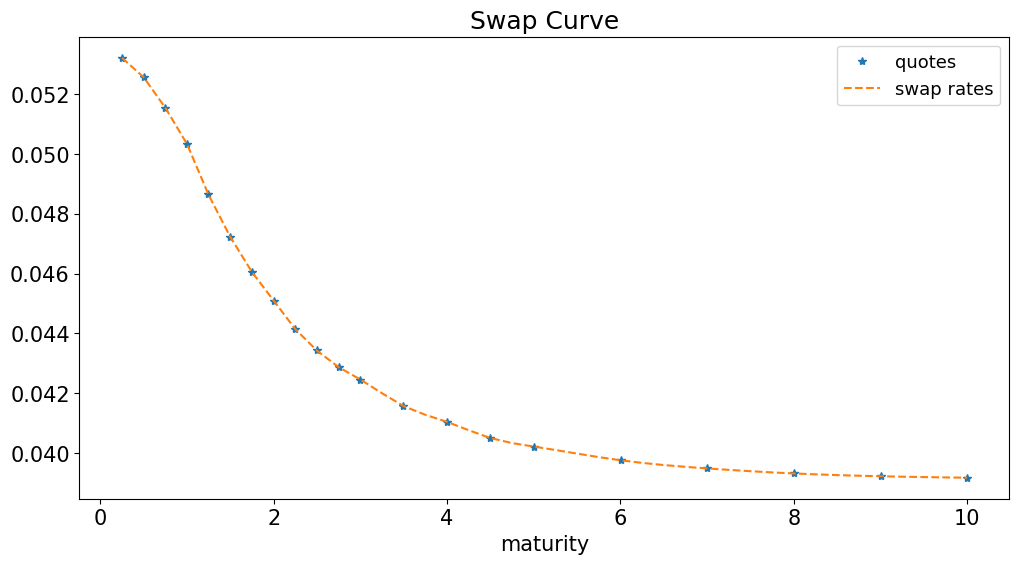

In [14]:
sofrcurves = interp_curves(sofrdata, dt = 1/freqcap, date=DATE, interp_method='cubicspline').rename(columns={'interp':'swap rates'})
sofrquotes = sofrdata.loc[DATE,:].rename('quotes')

### Plot the Curve
fig, ax = plt.subplots()
sofrquotes.plot.line(ax=ax, linestyle='None',marker='*')
sofrcurves['swap rates'].plot.line(ax=ax, linestyle='--',marker='')
plt.legend();
plt.title('Swap Curve');

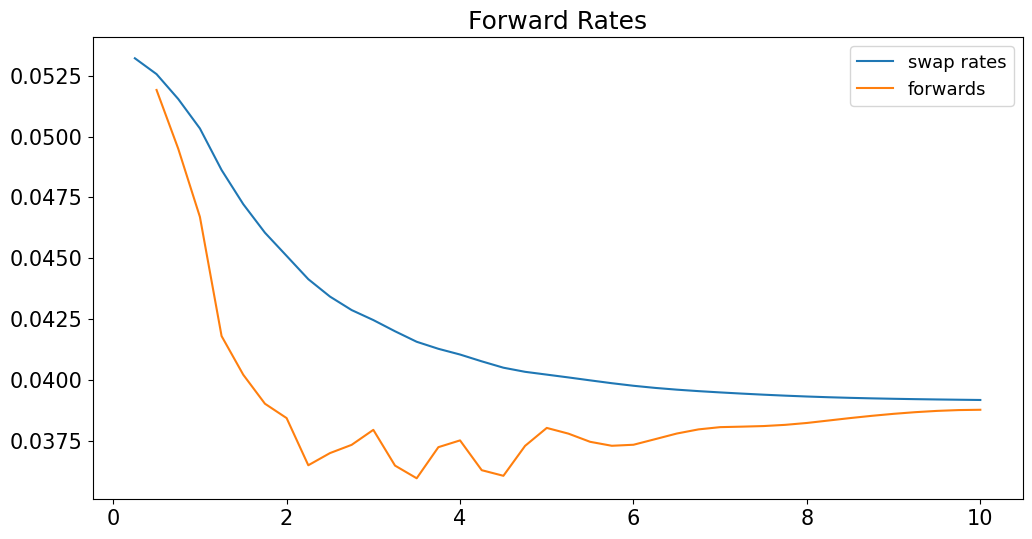

In [15]:
sofrcurves['discounts'] = ratecurve_to_discountcurve(sofrcurves['swap rates'],n_compound=freqcap)
sofrcurves['forwards'] = ratecurve_to_forwardcurve(sofrcurves['swap rates'],n_compound=freqcap)
sofrcurves[['swap rates','forwards']].plot(title='Forward Rates');

# Cap Quotes

In [16]:
SHEET = 'cap'
capdata = pd.read_excel(f'{FILEIN}.xlsx', sheet_name=SHEET).set_index('date')
capdata.columns = capdata.loc['maturity'] 
capdata.drop(index=['maturity'],inplace=True)
capdata.index = pd.to_datetime(capdata.index)

Bloomberg reported years-to-maturity are precise.
Round these to nearest $dt$ for better column headers
For more precise work, would need to make use of the precise maturities, but for this purpose will make no difference.

In [17]:
capdata.columns = (freqcap * capdata.columns.values).round(0)/freqcap
capdata.columns.name ='maturity'

Bloomberg allows downloading of ticker codes corresponding to 10.X years, but they are really just the 10-year code.

Called ticker list built to check all partial years, so it gets these redundant 10-year columns.

In [18]:
capdata = capdata.T.drop_duplicates().T

## Adjusting Normal Vol to Lognormal (Black) Vol

Cap quotes in Bloomberg are downloaded in
* normal vol
* terminal allows view of lognormal (Black) vol, but API seemingly restricts to normal.

The normal vols are reported in basis points.
* divide out by $100^2$

Converting between normal and lognormal vol is given by a simple formula for ATM options, (according to SABR, etc.)

$$\sigma_B = \frac{\sigma_N}{f}$$

where $f$ is the forward rate.

In [19]:
capquotes = capdata.loc[DATE,:].to_frame()
capquotes.columns = ['normal']
capquotes[DATE] = capquotes['normal'] / sofrcurves['forwards'] / 100**2

# Interpolate or Extrapolate

Interpolate/extrapolate just to get to quarterly frequency needed for forward vol extraction.

After extracting forward vol, can interpolate/extrapolate further for matching timegrid of binomial trees.

#### Interpolation
Need to interpolate cap rates for quarterly frequency as Bloomberg reports only at annual tenors.

Try `cubicspline`.

#### Extrapolation
Also need to extrapolate the short end of the curve, $t<1$.
* This can lead to negative values w/ cubic spline and others.
* Here, ad hoc set front to `FRONT_RATIO` the first quote and linearly extrapolate

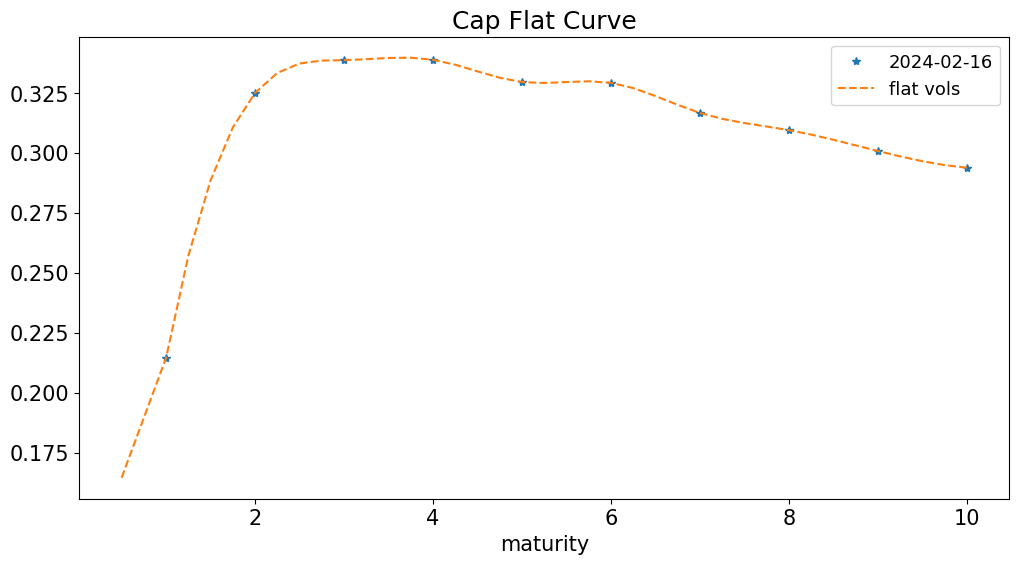

In [22]:
LIN_EXTRAP = True
FRONT_RATIO = .65

capcurves = interp_curves(capquotes[[DATE]].T,dt=1/freqcap, date=DATE,interp_method='cubicspline').rename(columns={'interp':'flat vols'})

if LIN_EXTRAP:
    fix_short = capcurves.loc[:1,'flat vols']
    fix_short.iloc[:-1] = np.nan
    fix_short.iloc[0] = capcurves.loc[1,'flat vols'] * FRONT_RATIO
    capcurves.loc[:1,'flat vols'] = fix_short.interpolate(limit_direction='both', fill_value = 'extrapolate')

# drop extrapolated value at first period as there is no caplet for the first period.
capcurves['flat vols'].iloc[0] = np.nan

### Plot the Curve
fig, ax = plt.subplots()
capquotes[[DATE]].rename(columns={'black':'quotes'}).plot.line(ax=ax, linestyle='None',marker='*')
capcurves['flat vols'].plot.line(ax=ax, linestyle='--',marker='')
plt.legend();
plt.title('Cap Flat Curve');

In [23]:
capcurves = flat_to_forward_vol_rev(capcurves['flat vols'],sofrcurves['swap rates'],sofrcurves['forwards'],sofrcurves['discounts'],freq=4)

### Save Data

In [24]:
outdata = pd.concat([sofrcurves.drop(columns=['quotes']), capcurves.drop(columns=['cap prices'])],axis=1)
outdata.index.name = 'tenor'

if SAVEDATA:    
    with pd.ExcelWriter(FILEOUT) as writer:  
        outdata.to_excel(writer, sheet_name= f'rate curves {DATE}', index=True)